This is part of a series of notebooks about practical time series methods:
* [Part 0: the basics](https://www.kaggle.com/konradb/ts-0-the-basics)
* [Part 1a: smoothing methods](https://www.kaggle.com/konradb/ts-1a-smoothing-methods)
* [Part 1b: Prophet](https://www.kaggle.com/konradb/ts-1b-prophet) 
* [Part 2: ARMA](https://www.kaggle.com/konradb/ts-2-arma-and-friends)
* [Part 3: Time series for finance](https://www.kaggle.com/konradb/ts-3-time-series-for-finance) 
* [Part 4: Sales and demand forecasting](https://www.kaggle.com/konradb/ts-4-sales-and-demand-forecasting)
* [Part 5: Automatic for the people](https://www.kaggle.com/code/konradb/ts-5-automatic-for-the-people) 
* [Part 6: Deep learning for TS - sequences](https://www.kaggle.com/konradb/ts-6-deep-learning-for-ts-sequences) - **this notebook**


The series is accompanied by video presentations on the YouTube channel of [Abhishek](https://www.kaggle.com/abhishek):
* [Talk 0](https://www.youtube.com/watch?v=cKzXOOtOXYY) 
* [Talk 1](https://www.youtube.com/watch?v=kAI67Sz92-s) - combining the content from parts 1a and 1b
* [Talk 2](https://www.youtube.com/watch?v=LjV5DE3KR-U) 
* [Talk 3](https://www.youtube.com/watch?v=74rDhJexmTg)
* [Talk 4](https://www.youtube.com/watch?v=RdH8zd07u2E) 
* [Talk 5](https://www.youtube.com/watch?v=wBP8Pc4Wxzs) 
* [Talk 6](https://www.youtube.com/watch?v=81AEI0tj0Kk) - **based on this notebook**

**If you think this notebook deserves an upvote, I'd love to have it. An upvote per view, its all I ask**
(credit to [Dan Carlin](https://twitter.com/HardcoreHistory) for coining the phrase ;-) 


---------------------------------------
Deep learning for time series is a huge topic, so I decided to break it down into parts. In this one, we will focus on a "vintage" (for deep learning standards)  sequence modeling: we start with RNN, then present GRU and LSTM (two approaches to handle the limitations of RNN) and close with a hybrid approach combining deep learning with exponential smoothing.

* [RNN](#section-one)
* [More is better](#section-two)
* [GRU](#section-three)
* [LSTM](#section-four)
* [Going all in](#section-five)



In [ ]:
import itertools
import pandas as pd
import numpy as np
import os
import random 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import GroupKFold

from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [ ]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024

    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   


def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(CFG.seed)

# Functions

In [ ]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [ ]:
def create_dataset(dataset, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back -look_ahead):
        xdat.append(df[i:i+ look_back ,0])
        ydat.append(df[i+ look_back : i + look_back + look_ahead,0])
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1,look_ahead)
    return xdat, ydat

In [ ]:
def prepare_split(xdat, ydat, cutoff = 5000, timesteps = 50):
    xtrain, xvalid = xdat[:cutoff,:], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff,:], ydat[cutoff:,]

    # reshape into [batch size, time steps, dimensionality]
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1)

    return xtrain, ytrain, xvalid, yvalid 


<a id="section-one"></a>
# RNN

We start with a crash introduction to Recurrent Neural Networks:

* **R**ecurrent **N**eural **N**etworks are a family of networks for processing sequential data (time series, text, audio, video) 

* not the only option: dense networks / [tabularization](https://www.kaggle.com/code/konradb/ts-4-sales-and-demand-forecasting) / 1D CNN

* analogy: CNN - filters with convolutional layers, RNN - activation from other points in the sequence (output of a layer) to generate the next output

* RNN have **memory**: prior input influence the current input and output $\rightarrow$ output depends on prior elements (unlike CNN with output-input independence)

\begin{equation}
h_t = f(h_{t-1}, x_t)
\end{equation}

* Schematics:

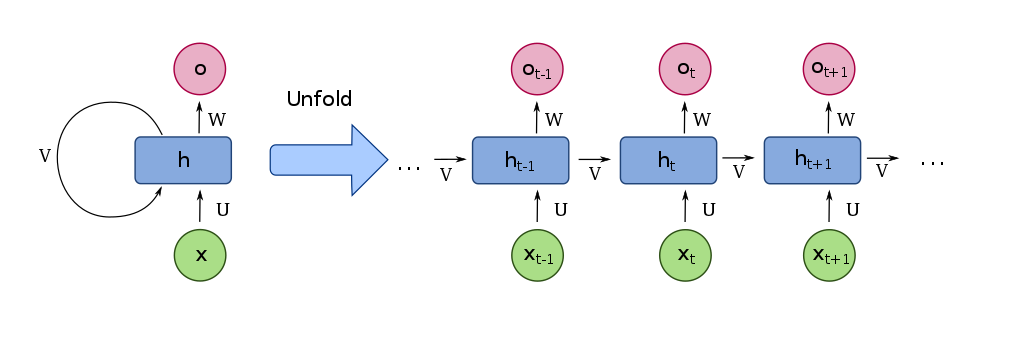


* the feedback loop $v$ is what enables us to work with sequences

* recurrent $\rightarrow$  they perform the same task for every element of a sequence, with the output being depended on the previous computations.

* input / output sequences:

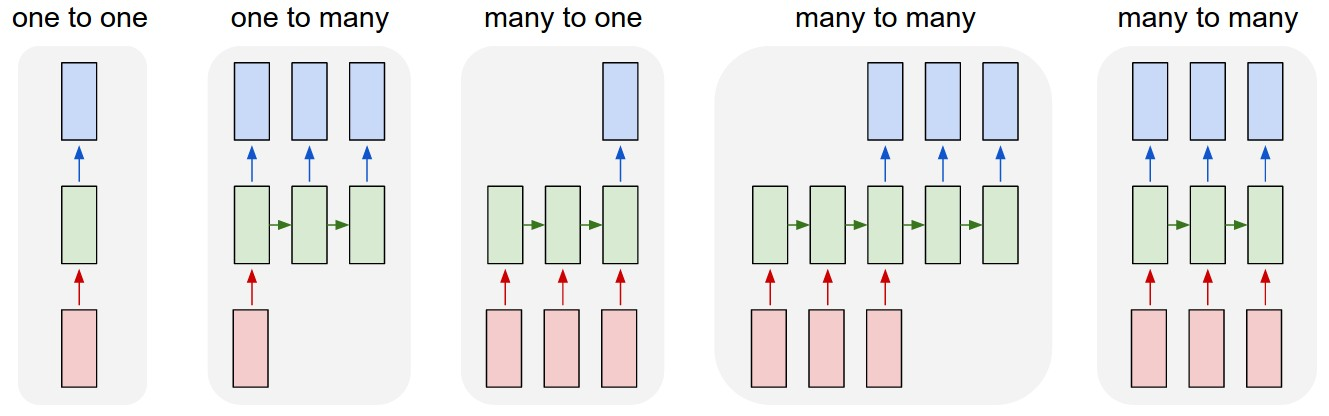

* Training: **B**ack**P**ropagation **T**hrough **T**ime = regular BP on network unrolled through time

* representation, not transformation! 

* BPTT: error from output to input, with errors summarised at each time step 

* In RNN weights and bias for all the nodes in each layer are same (parameter sharing) $\implies$ handling arbitrary length sequences

* RNN unit ([source](https://medium.com/analytics-vidhya/rnn-vs-gru-vs-lstm-863b0b7b1573)):

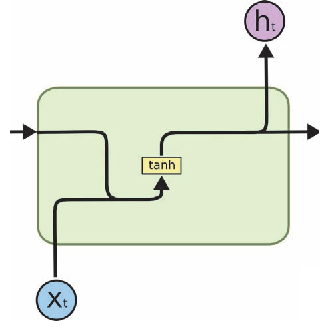





How does the learning process actually work? 

* 3D input: `[batch size, number of steps, number of features]`

* intuition: https://towardsdatascience.com/tutorial-on-lstm-a-computational-perspective-f3417442c2cd#95b4

* number of time steps = nof segments you will pass in one line of input to RNN

* data representation inside a batch: 

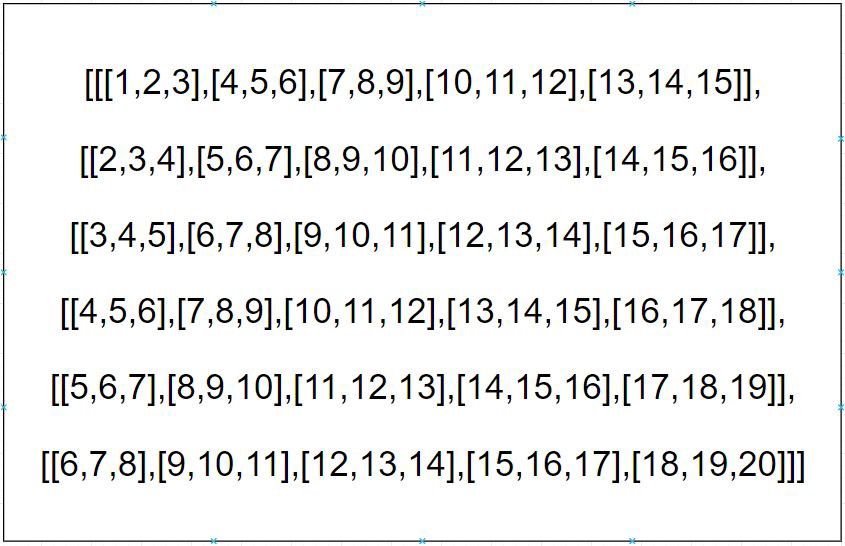

* processing the data $\implies$ unrolling the network

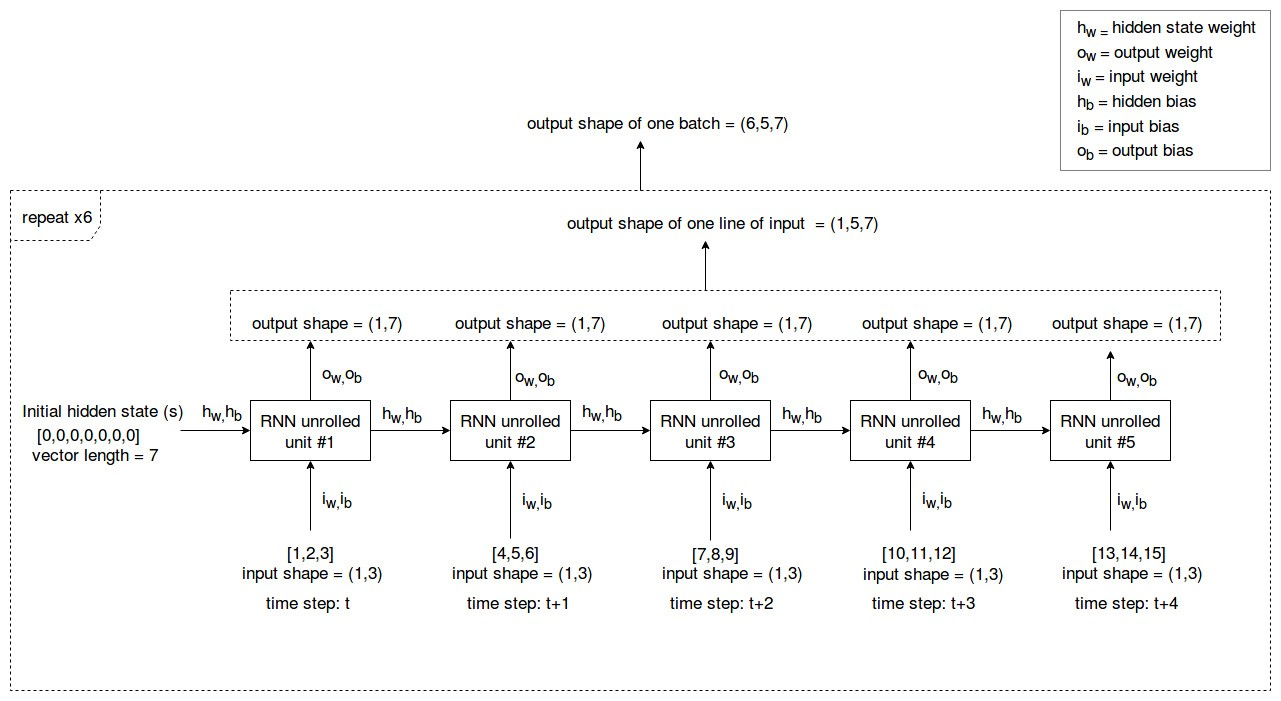


* in order to process a line of input, the RNN cell unrolls “number of steps” times.


This is a condensed version of the explanation from: https://towardsdatascience.com/all-you-need-to-know-about-rnns-e514f0b00c7c

This was geared towards time series - for a general, gentle and great intro see the blog post of Andrej Karpathy: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

For the math behind BPTT: https://towardsdatascience.com/recurrent-neural-networks-rnns-3f06d7653a85  




With the theoretical background out of the way, let's fit our first RNN - we will do it block-by-block using `Keras`, but you can always go the [automated route](https://www.kaggle.com/code/konradb/ts-5-automatic-for-the-people) if that is your heart's desire. 

In [ ]:
# load the dataset
stock_name = 'TATASTEEL'

df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",  inplace=True)
df.VWAP.plot(xlabel = '')

When dealing with time series through RNN we typically - wrappers like `Kats` or `darts` notwithstanding - need to format the input data into a shape `[batch size, time steps, dimensionality]` where the last one is 1 for univariate series (single step ahead predictions) and more for multivariate ones (including univariate series + covariates, as we shall see later).

In [ ]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [ ]:
# use 50 historical observations, predict 1 step ahead
look_back = 50
look_ahead = 1

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

# We only want to forecast a single value for each series => target is a column
print(xdat.shape, ydat.shape)


Our `prepare_split` function takes care of reshaping the data into `[batch size, time steps, dimensionality]`

In [ ]:

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps = look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)


Build the simplest RNN model: 
- single RNN layer
- single output neuron

In [ ]:
def create_model1():    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model1 = create_model1()


In [ ]:
model1.summary()

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

model1.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

In [ ]:
# predict and calculate RMSE
y_pred1 = model1.predict(xvalid)
y_pred1 = scaler.inverse_transform(y_pred1)
yvalid1 =  scaler.inverse_transform(yvalid)


In [ ]:
print('RMSE: ' + str(my_rmse(y_pred1, yvalid1)))

In [ ]:
plt.plot(yvalid1, label = 'real')
plt.plot(y_pred1, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

If a single RNN layer does a decent job, how about stacking two?

In [ ]:
# def create_model2():    
    
#     model=Sequential()
#     model.add(SimpleRNN(10,input_shape= [None,1]))
#     model.add(SimpleRNN(10,input_shape= [None,1]))
#     model.add(Dense(1))
    
#     model.compile(loss='mean_squared_error',optimizer='adam')
#     return model
    
# model2 = create_model2()
# model2.summary()

A likely error you can get while building RNN-based architecture is:

`ValueError: Input 0 of layer simple_rnn_2 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 10)`

By default a recurrent layer only returns the final output - if we want the output for each time step we set `return_sequences = True`

In [ ]:
def create_model2():    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model2 = create_model2()
model2.summary()

In [ ]:
model2.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred2 = model2.predict(xvalid)
y_pred2 = scaler.inverse_transform(y_pred2)
print('RMSE: ' + str(my_rmse(y_pred2, scaler.inverse_transform(yvalid))))

<a id="section-two"></a>
# More is better

Let's be honest: the reason everyone loves the RNN family of models is their ability to predict sequences. We can replicate the exercise above but this time predicting multiple steps ahead (making it a many-to-one problem):


In [ ]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

print(xdat.shape, ydat.shape)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)


In [ ]:
def create_model3(out_dim):    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model3 = create_model3(out_dim = look_ahead)
model3.summary()

In [ ]:
model3.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred3 = model3.predict(xvalid)
y_pred3 = scaler.inverse_transform(y_pred3)

In [ ]:
print('RMSE: ' + str(my_rmse(y_pred3, scaler.inverse_transform(yvalid))))

### Vanishing gradient

The performance of our RNN model starts to suffer for longer time horizons. It is in general expected with all forecasting models if we go far enough, but with RNN the problem tends to be acute. The issue is related to the mechanics of how BPTT work:

* at each step the gradient is calculated and used to update weights in the network

* small magnitude $\implies$ exponential decay (or growth!) through time

* network fails to learn earlier inputs


* in graphic form: shade = sensitivity of the node to input $\rightarrow$ network "forgets" the first input ([source](https://towardsdatascience.com/tutorial-on-lstm-a-computational-perspective-f3417442c2cd#95b4)):

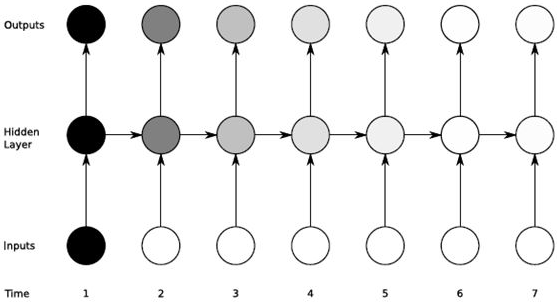


Where do we go from there?

<a id="section-three"></a>
# GRU

One approach to solving the RNN problem is a **G**ated **R**ecurrent **U**nit: 

* same workflow, different operation inside a unit ([source](https://medium.com/analytics-vidhya/rnn-vs-gru-vs-lstm-863b0b7b1573)):

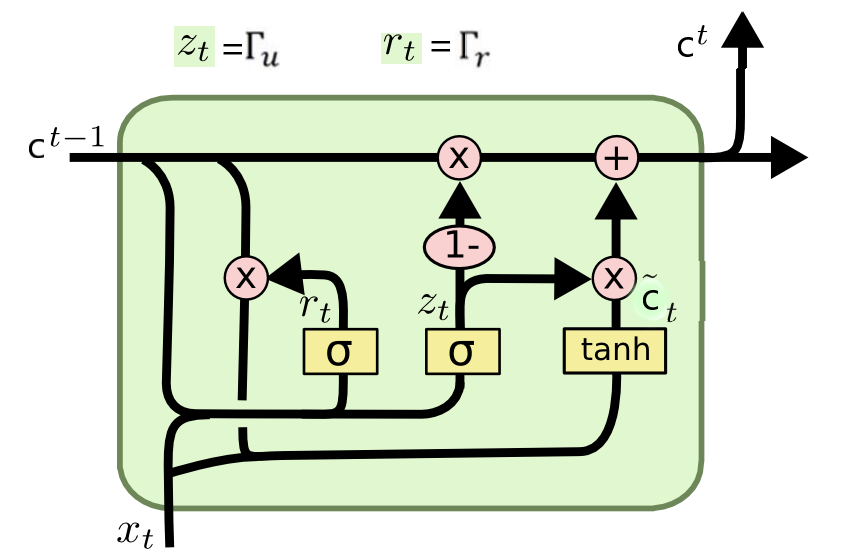!

* used a hidden state

* two gates: reset and update $\rightarrow$ control how much / which information to retain

* reset gate:  used to decide whether the previous cell state is important or not; not always used. If close to 0, previous hidden state is mostly ignored: model drops information irrelevant to the future.

* update gate: decides if the cell state should be updated with the candidate state (current activation value) or not. If close to 1, we can copy information in that unit through subsequent steps

* candidate cell: hidden state(activation) of RNN

* final cell state:  dependent on the update gate, It may or may not be updated with candidate state. Remove some content from last cell state, and write some new cell content. In GRU the final cell state is directly passing as the activation to the next cell.


Let's examine how moving from (Simple)RNN to GRU impacts the quality of our solution:

In [ ]:
def create_model4(out_dim):    
    
    model=Sequential()
    model.add(GRU(10,input_shape= [None,1], return_sequences = True))
    model.add(GRU(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model4 = create_model4(out_dim = look_ahead)
model4.summary()

In [ ]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)



In [ ]:
model4.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred4 = model4.predict(xvalid)
y_pred4 = scaler.inverse_transform(y_pred4)


In [ ]:
print('RMSE: ' + str(my_rmse(y_pred4, scaler.inverse_transform(yvalid))))

<a id="section-four"></a>
# LSTM

A second popular approach to handling the issues with RNN is using **L**ong **S**hort-**T**erm **M**emory units:

* LSTM have two more gates compared to GRU: forget and output. 

* Forget gate: controls what is kept vs forgotten, from previous cell state. In laymen terms, it will decide how much information from the previous state should be kept and forget remaining.

* Output gate: controls which parts of the cell are output to the hidden state. It will determine what the next hidden state will be.


* LSTM unit ([source](https://medium.com/analytics-vidhya/rnn-vs-gru-vs-lstm-863b0b7b1573)): 

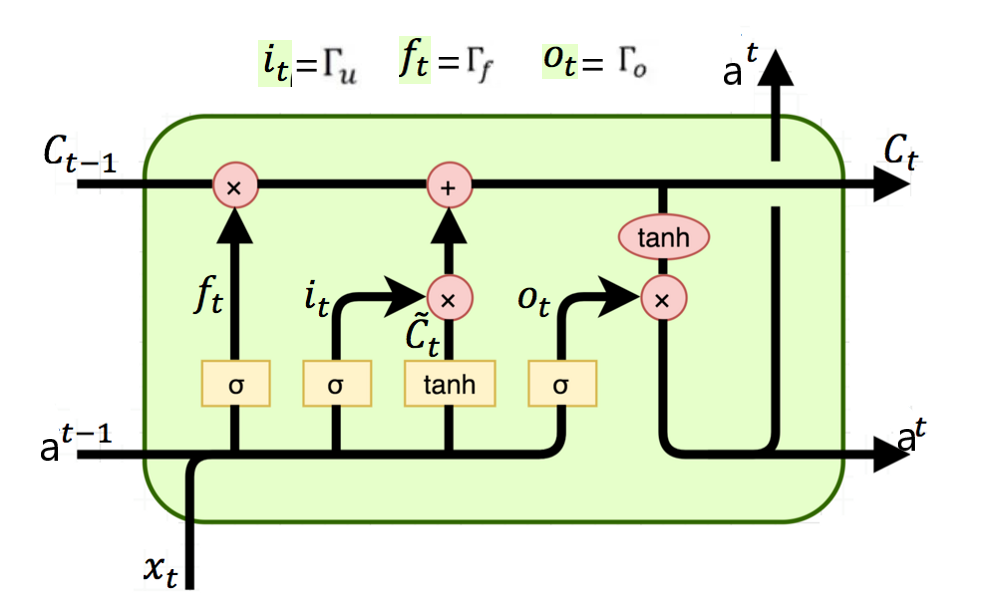

* multiple channels through which data can pass to maintain information

* two main paths: short-term (= bottom) and long-term memory (= top)

* short-term: incorporates new data and the previous step output

* long-term: uses inputs from previous long-term memory output and incorporates different updates

* connections between the two: different intermediary output + activation functions 

* channel 1: sigmoid (0 to 1) dictates the importance of the current input for long-term memory

* channel 2,3: hyp tan (-1 to 1) - is the current information relevant and did it contribute positively or negatively

* channel 4: combine current time step with current understanding (from long-term path) $\rightarrow$ this output is the input to the next LSTM cell


We can think of GRU as a simplified version of LSTM (although younger and leaner):
* both state vectors are merged 
* single gate control affects both the forget gate and nthe input gate
* there is no output gate


How is our solution performing?

In [ ]:
def create_model5(out_dim):    
    
    model=Sequential()
    model.add(LSTM(10,input_shape= [None,1], return_sequences = True))
    model.add(LSTM(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model5 = create_model5(out_dim = look_ahead)
model5.summary()

In [ ]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)


In [ ]:
model5.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred5 = model5.predict(xvalid)
y_pred5 = scaler.inverse_transform(y_pred5)

In [ ]:
print('RMSE: ' + str(my_rmse(y_pred5, scaler.inverse_transform(yvalid))))

<a id="section-five"></a>
# Going all in

We started with predicting a value of a univariate series one step ahead using `SimpleRNN`, with subsequent sections extending the horizon and the cell type used. Two more steps remain to make a model fully general: 1. multivariate time series 2. covariates. Since both of those are fairly straighforward (with the basis we have built so far), we will handle them together in this section. 

We will use the data from the Google Brain - Ventilator competition https://www.kaggle.com/competitions/ventilator-pressure-prediction. In this contest, participants had to predict were presented data from ventilators connected to a sedated patient's lung and the objective was to simulate the ventilator behaviour, i.e. correctly predict the airway pressure in the respiratory circuit during the breath. The competition had some interesting aspects (some data quality issues, custom metric, reverse-engineering the underlying physics of the process), but we will focus purely on the time series angle and model our data using a many-to-many LSTM with covariates. 


In [ ]:
# start by loading the data

xtrain = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
xtrain.head(5)

Quick examination of the data:

In [ ]:
xtrain.groupby('breath_id')['u_in'].count()

In [ ]:
xtest = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
xtest.groupby('breath_id')['u_in'].count()

In [ ]:
np.intersect1d(xtrain['breath_id'].unique(), xtest['breath_id'].unique())

The `breath_id` variable has no overlap between training and test $\implies$ this is what we will split the folds on. What does the data look like for one particular patient?

In [ ]:
del xtest

fig, ax1 = plt.subplots()

breath_1 = xtrain.loc[xtrain['breath_id'] == 1]
ax2 = ax1.twinx()

ax1.plot(breath_1['time_step'], breath_1['pressure'], 'r-', label='pressure')
ax1.plot(breath_1['time_step'], breath_1['u_in'], 'g-', label='u_in')
ax2.plot(breath_1['time_step'], breath_1['u_out'], 'b-', label='u_out')

ax1.set_xlabel('Timestep')

ax1.legend(loc=(1.1, 0.8))
ax2.legend(loc=(1.1, 0.7))
plt.show()

We generate some simple features (subset of fantastic FE performed in https://www.kaggle.com/code/artgor/ventilator-pressure-prediction-eda-fe-and-models): 

In [ ]:
xgr = xtrain.groupby('breath_id')['u_in']
xtrain['last_value_u_in'] = xgr.transform('last')
xtrain['u_in_cumsum'] = xgr.cumsum()
xtrain['u_in_lag1'] = xgr.shift(1)
xtrain['u_in_lag_back1'] = xgr.shift(-1)
xtrain.fillna(0, inplace = True)


xtrain['R'] = xtrain['R'].astype(str)
xtrain['C'] = xtrain['C'].astype(str)
xtrain = pd.get_dummies(xtrain)
    
del xgr

xtrain.head(3)

print(xtrain.shape)

In [ ]:
# clean up the data

ytr_ref = xtrain['pressure'].copy()
unibreath_tr = xtrain['breath_id'].unique()

ytrain = xtrain[['pressure']].copy()
id_train = xtrain['id']
breathid = xtrain['breath_id']
uout = xtrain['u_out']
xtrain.drop(['pressure', 'id', 'breath_id'], axis=1, inplace=True)

# # make sure nof columns is not hardcoded
# nof_cols = xtrain.shape[1]

In [ ]:
print(xtrain.shape, ytrain.shape)

# scale
RS = RobustScaler()
xtrain = RS.fit_transform(xtrain)

# reshape to [batch size, time steps, dimensionality]
xtrain = xtrain.reshape(-1, 80, xtrain.shape[-1])
ytrain = ytrain.to_numpy().reshape(-1, 80)

print(xtrain.shape, ytrain.shape)

A problem is slightly more complicated than before, so we need a more elaborate architecture: `Bidirectional` is a wrapper we can use around any RNN-type layer to connect two hidden layers from opposite direction to the same input. Useful in our context, as it handles the context.

In [ ]:
def create_model_bigger():

    model = Sequential([
            Input(shape = xtrain.shape[-2:]),
            Bidirectional(LSTM(400, return_sequences = True)),
            Bidirectional(LSTM(300, return_sequences = True)),
            Bidirectional(LSTM(200, return_sequences = True)),
            Bidirectional(LSTM(100, return_sequences = True)),
            Dense(50, activation = 'selu'),
            Dense(1),
        ])
    
    model.compile(optimizer = "adam", loss = "mae")
    
    return model

With the data prepared, we can move to modeling: based on the input sequence, we generate a predicted path (80 observations of `pressure`) for each patient identified by `breath_id`

In [ ]:
gkf = GroupKFold(n_splits = 5)


for (fold, (id0, id1)) in enumerate(gkf.split(xtrain, ytrain, groups = breathid.unique())):
    

    X_train, X_valid = xtrain[id0], xtrain[id1]
    y_train, y_valid = ytrain[id0], ytrain[id1]
        
    # create the model
    model = create_model_bigger()        

    scheduler = ExponentialDecay(1e-3, 400*((len(X_train)*0.8)/CFG.BATCH_SIZE), 1e-5)
    lr = LearningRateScheduler(scheduler, verbose = 1)
    
    early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

    # fit 
    model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = CFG.nepochs, 
              batch_size = CFG.BATCH_SIZE, callbacks = [early_stop , lr])

    print('fold: ' + str(fold))
    

    break

As you have seen above, if an RNN can do it then LSTM/GRU can do it better. Can those be overtaken by Transformers? Find out in the next episode dedicated to deep learning for time series.